In [111]:
from osgeo import gdal, osr
input_file = r"../data\raw\AMSRU_Mland_2017001A.tif"
dataset = gdal.Open(input_file)

projection = dataset.GetProjection()
geotransform = dataset.GetGeoTransform()

In [190]:
print(geotransform)# Affine transformation 
""" 
GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
GT(1) w-e pixel resolution / pixel width.
GT(2) row rotation (typically zero).
GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
GT(4) column rotation (typically zero).
GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
"""

#This checks with the 25.000m resolution, the pixel corners are also the same as the ones listed in the EASE grid website for EASE v1 25km res.
# Although the exact coordinate for the pixel is not wright. Also lets correct the resolution

corrected_geotransform = (-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)

(-17334193.54, 25067.56, 0.0, 7344784.83, 0.0, -25067.56)


In [112]:
source_srs = osr.SpatialReference()
source_srs.ImportFromEPSG(3410)

target_srs =osr.SpatialReference()
target_srs.ImportFromEPSG(6933)

0

In [113]:
transform = osr.CoordinateTransformation(source_srs,target_srs)

In [114]:
output_file = r"../data/processed/reprojected_v1.tif"
driver = gdal.GetDriverByName("GTiff")
output_dataset = driver.Create(output_file, dataset.RasterXSize, dataset.RasterYSize, dataset.RasterCount, gdal.GDT_Float32)
output_dataset.SetProjection(target_srs.ExportToWkt())
output_dataset.SetGeoTransform(geotransform)

0

In [115]:
for i in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(i)
    reprojected_band = output_dataset.GetRasterBand(i)
    gdal.ReprojectImage(dataset, output_dataset, projection, target_srs.ExportToWkt(), gdal.GRA_NearestNeighbour)

# Close the files
dataset = None
output_dataset = None


In [116]:
# Open the rerpojected geotiff
import xarray
r_dataset = xarray.open_dataarray(output_file)

In [117]:
r_dataset

<xarray.DataArray 'band_data' (band: 7, y: 586, x: 1383)>
[5673066 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7
  * x            (x) float64 -1.732e+07 -1.73e+07 ... 1.73e+07 1.732e+07
  * y            (y) float64 7.332e+06 7.307e+06 ... -7.307e+06 -7.332e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area

In [220]:
from osgeo import gdal, osr

input_file = r"../data\raw\AMSRU_Mland_2017001A.tif"
dataset = gdal.Open(input_file)

projection = dataset.GetProjection()
# geotransform = dataset.GetGeoTransform()

# Reading the geostransform from the dataset results in some inconsistencies in the decimal places. This is taken from https://nsidc.org/data/user-resources/help-center/guide-ease-grids EASEv2 25km
geotransform = (-17334193.54, 25067.53, 0.0, 7344784.83, 0.0, -25067.53)

# TODO: Specify the Geoid in this projections.
source_srs = osr.SpatialReference()
source_srs.ImportFromEPSG(3410)

target_srs = osr.SpatialReference()
target_srs.ImportFromEPSG(6933)

transform = osr.CoordinateTransformation(source_srs, target_srs)

output_file = r"../data/processed/reprojected_resampled_v1.tif"
driver = gdal.GetDriverByName("GTiff")

# Define output dimensions based on desired shape (584, 1388)
output_width = 1388
output_height = 584

# # Define output geotransform based on desired resolution (25km)
# x_res = 25025.26
# y_res = -25025.26  # negative value for EASE grid v2
# output_geotransform = (geotransform[0], x_res, 0, geotransform[3], 0, y_res)
output_geotransform = (-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)

# Create the output dataset with the desired shape and geotransform
output_dataset = driver.Create(output_file, output_width, output_height, dataset.RasterCount, gdal.GDT_Float32)
output_dataset.SetProjection(target_srs.ExportToWkt())
output_dataset.SetGeoTransform(output_geotransform)

# Reproject and resample using gdal.Warp()
gdal.Warp(output_dataset, dataset, dstSRS=target_srs.ExportToWkt(), width=output_width, height=output_height, resampleAlg=gdal.GRA_Bilinear)

# Close the files
dataset = None
output_dataset = None


In [221]:
print(source_srs.ExportToPrettyWkt())

PROJCS["NSIDC EASE-Grid Global",
    GEOGCS["NSIDC Authalic Sphere",
        DATUM["NSIDC_International_1924_Authalic_Sphere",
            SPHEROID["International 1924 Authalic Sphere",6371228,0,
                AUTHORITY["EPSG","7057"]],
            AUTHORITY["EPSG","1360"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","10346"]],
    PROJECTION["Cylindrical_Equal_Area"],
    PARAMETER["standard_parallel_1",30],
    PARAMETER["central_meridian",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","3410"]]


In [222]:
print(target_srs.ExportToPrettyWkt())

PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Cylindrical_Equal_Area"],
    PARAMETER["standard_parallel_1",30],
    PARAMETER["central_meridian",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","6933"]]


In [223]:
print(projection.replace(",","\n"))

PROJCS["NSIDC EASE-Grid Global"
GEOGCS["NSIDC Authalic Sphere"
DATUM["NSIDC_International_1924_Authalic_Sphere"
SPHEROID["International 1924 Authalic Sphere"
6371228
0
AUTHORITY["EPSG"
"7057"]]
AUTHORITY["EPSG"
"1360"]]
PRIMEM["Greenwich"
0
AUTHORITY["EPSG"
"8901"]]
UNIT["degree"
0.0174532925199433
AUTHORITY["EPSG"
"9122"]]
AUTHORITY["EPSG"
"10346"]]
PROJECTION["Cylindrical_Equal_Area"]
PARAMETER["standard_parallel_1"
30]
PARAMETER["central_meridian"
0]
PARAMETER["false_easting"
0]
PARAMETER["false_northing"
0]
UNIT["metre"
1
AUTHORITY["EPSG"
"9001"]]
AXIS["Easting"
EAST]
AXIS["Northing"
NORTH]
AUTHORITY["EPSG"
"3410"]]


In [224]:
# Open the rerpojected geotiff
import xarray
r_dataset = xarray.open_dataarray(output_file)
r_dataset

<xarray.DataArray 'band_data' (band: 7, y: 584, x: 1388)>
[5674144 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7
  * x            (x) float64 -1.736e+07 -1.733e+07 ... 1.733e+07 1.736e+07
  * y            (y) float64 7.295e+06 7.27e+06 ... -7.27e+06 -7.295e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2021:03:16 22:21:13
    TIFFTAG_DOCUMENTNAME:      Y:/data/LPDR_v2/GeoTIFF/2017/AMSRU_Mland_20170...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.7.2, Harris Geospatial Solutions, Inc.
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100

--- 

DONE, now lets seeif it worked

In [225]:
# Same as in Reprojecting noteboo, to check if the pixels line up with the AMSR2 data

# load and manage a v2 data file for later:
# Data in easev2 for comparison
v2_path = r"../data\raw\ka_36ghz\Ascending\GW1AM2_20170101_01D_EQMA_L3SGT36LA2220220_corrected.h5"
v2_data = xarray.open_dataset(v2_path)

# Apply the v2 data scaling factors:
for dvar in v2_data.data_vars:
    v2_data[dvar] *= v2_data[dvar].attrs["SCALE FACTOR"]



In [226]:
# calculate the lat and lon coordiantes based on the new projection for better ploting with cartopy
from pyproj import Transformer
import numpy as np
# Re calculate the lat-lon for this projection:
transformer = Transformer.from_crs(6933,4326)

x_matrix, y_matrix = np.meshgrid(r_dataset['x'].values, r_dataset['y'].values)

def xy_to_latlon(x, y):
    lon, lat = transformer.transform(x, y)
    return lat, lon


lon_coords, lat_coords = xy_to_latlon(y=y_matrix.flatten(), x=x_matrix.flatten())

lat_coords = lat_coords.reshape(y_matrix.shape)
lon_coords = lon_coords.reshape(x_matrix.shape)

r_dataset["lon"] = xarray.DataArray(
    lon_coords[0,:],
    coords={'x': r_dataset['x']},
    dims=["x"]
)

r_dataset["lat"] = xarray.DataArray(
    lat_coords[:,0],
    coords={'y': r_dataset['y']},
    dims=["y"]
)
r_dataset.coords

Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7
  * x            (x) float64 -1.736e+07 -1.733e+07 ... 1.733e+07 1.736e+07
  * y            (y) float64 7.295e+06 7.27e+06 ... -7.27e+06 -7.295e+06
    spatial_ref  int32 ...
    lon          (x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    lat          (y) float64 83.52 81.98 80.7 79.57 ... -80.7 -81.98 -83.52

(30.0, 60.0)

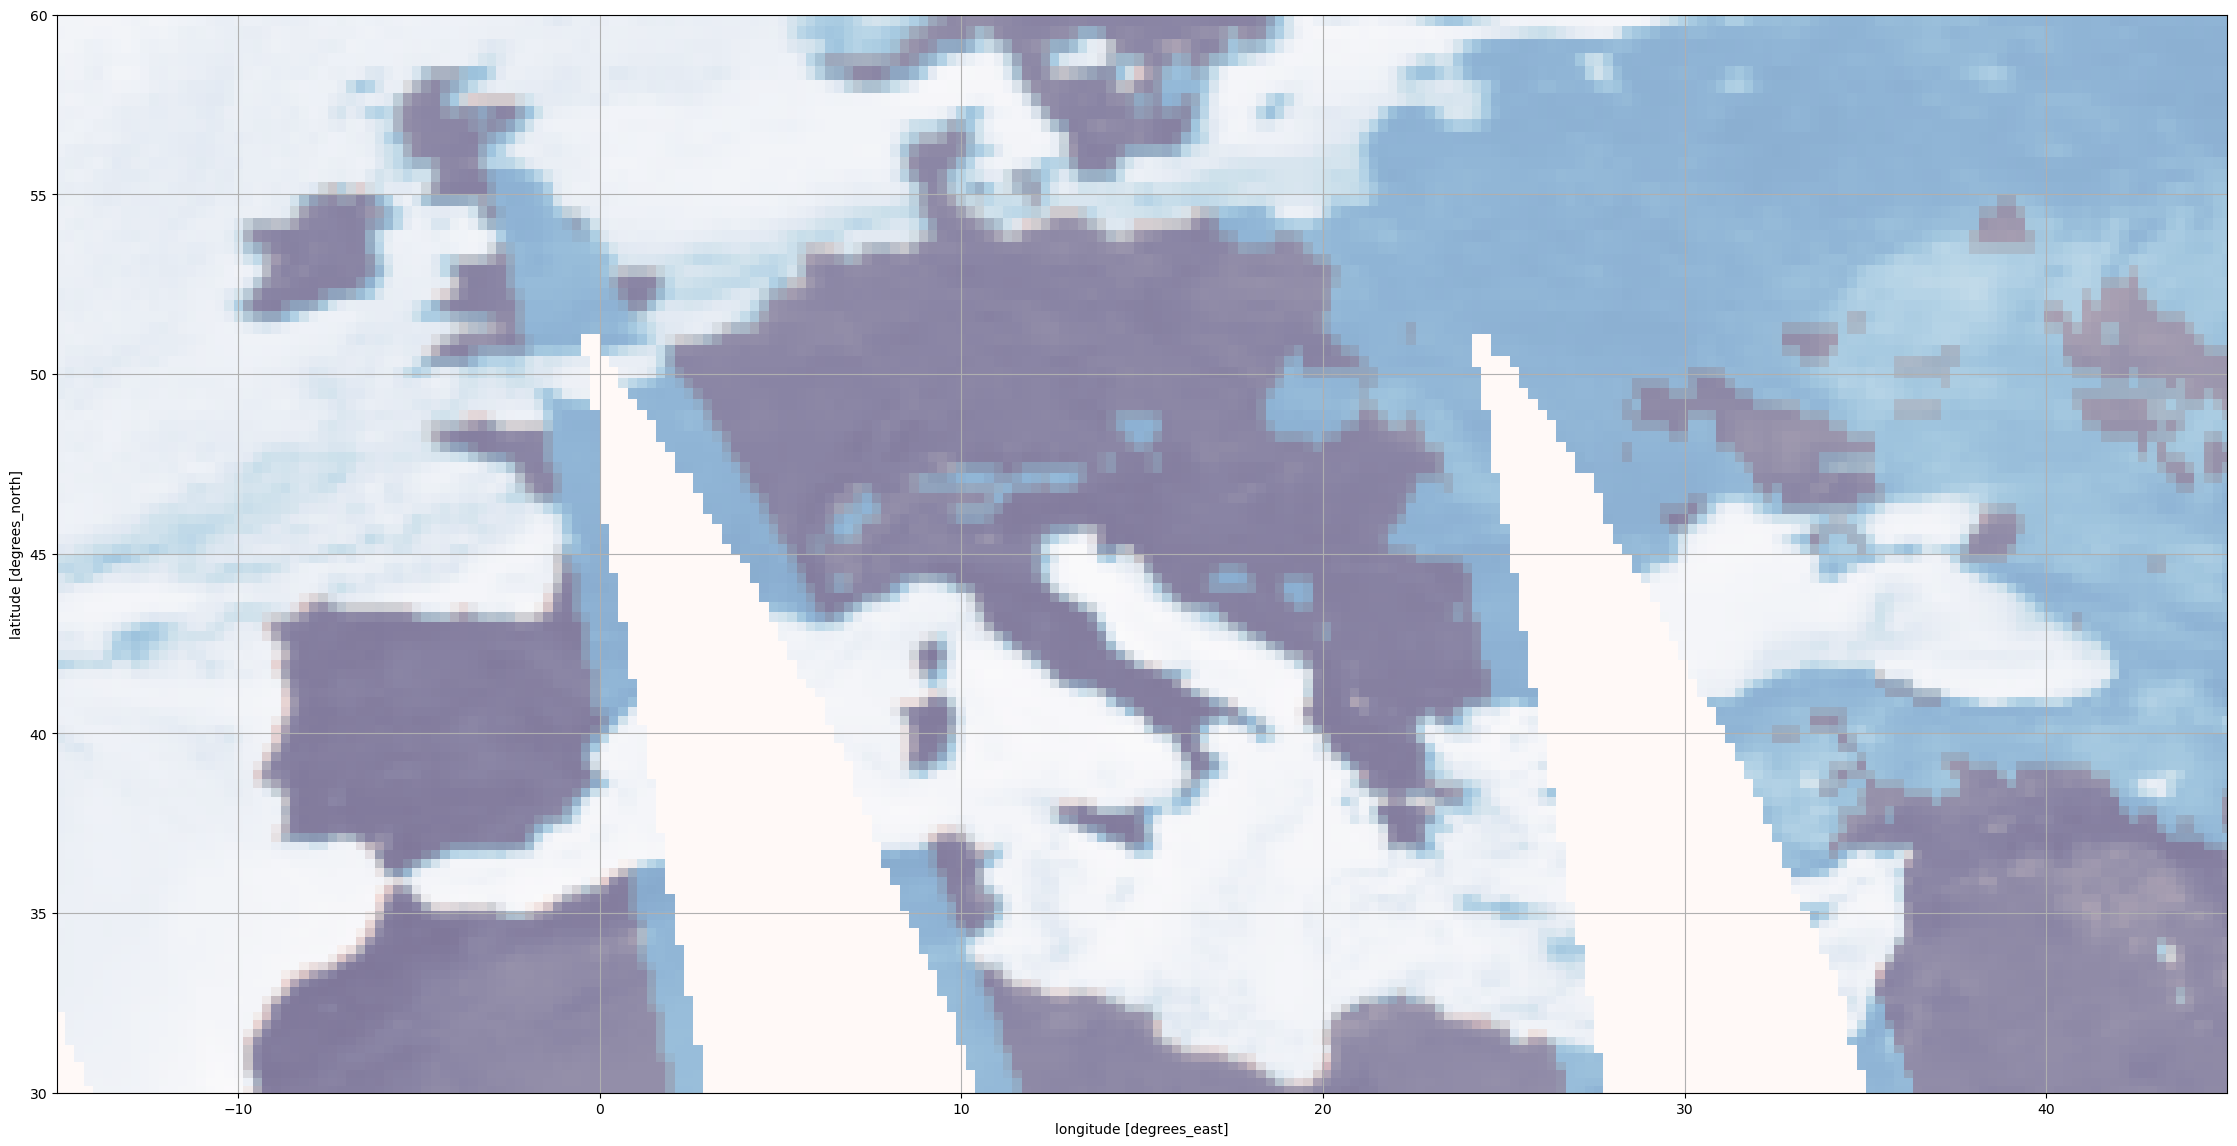

In [227]:
# Regular image plot:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize = (28,14))
r_dataset.sel(band=3).plot(x = "lon", y ="lat", ax = ax, alpha = 0.5, cmap = "Reds", add_colorbar=False)

# bplot and compare with v2 data
v2_data["Brightness Temperature (H)"].plot(x = "lon", y ="lat", ax = ax, alpha = 0.5, cmap = "Blues", add_colorbar=False)
ax.grid()
x_lims = (-15,45)
y_lims = (30,60)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

(20.0, 70.0)

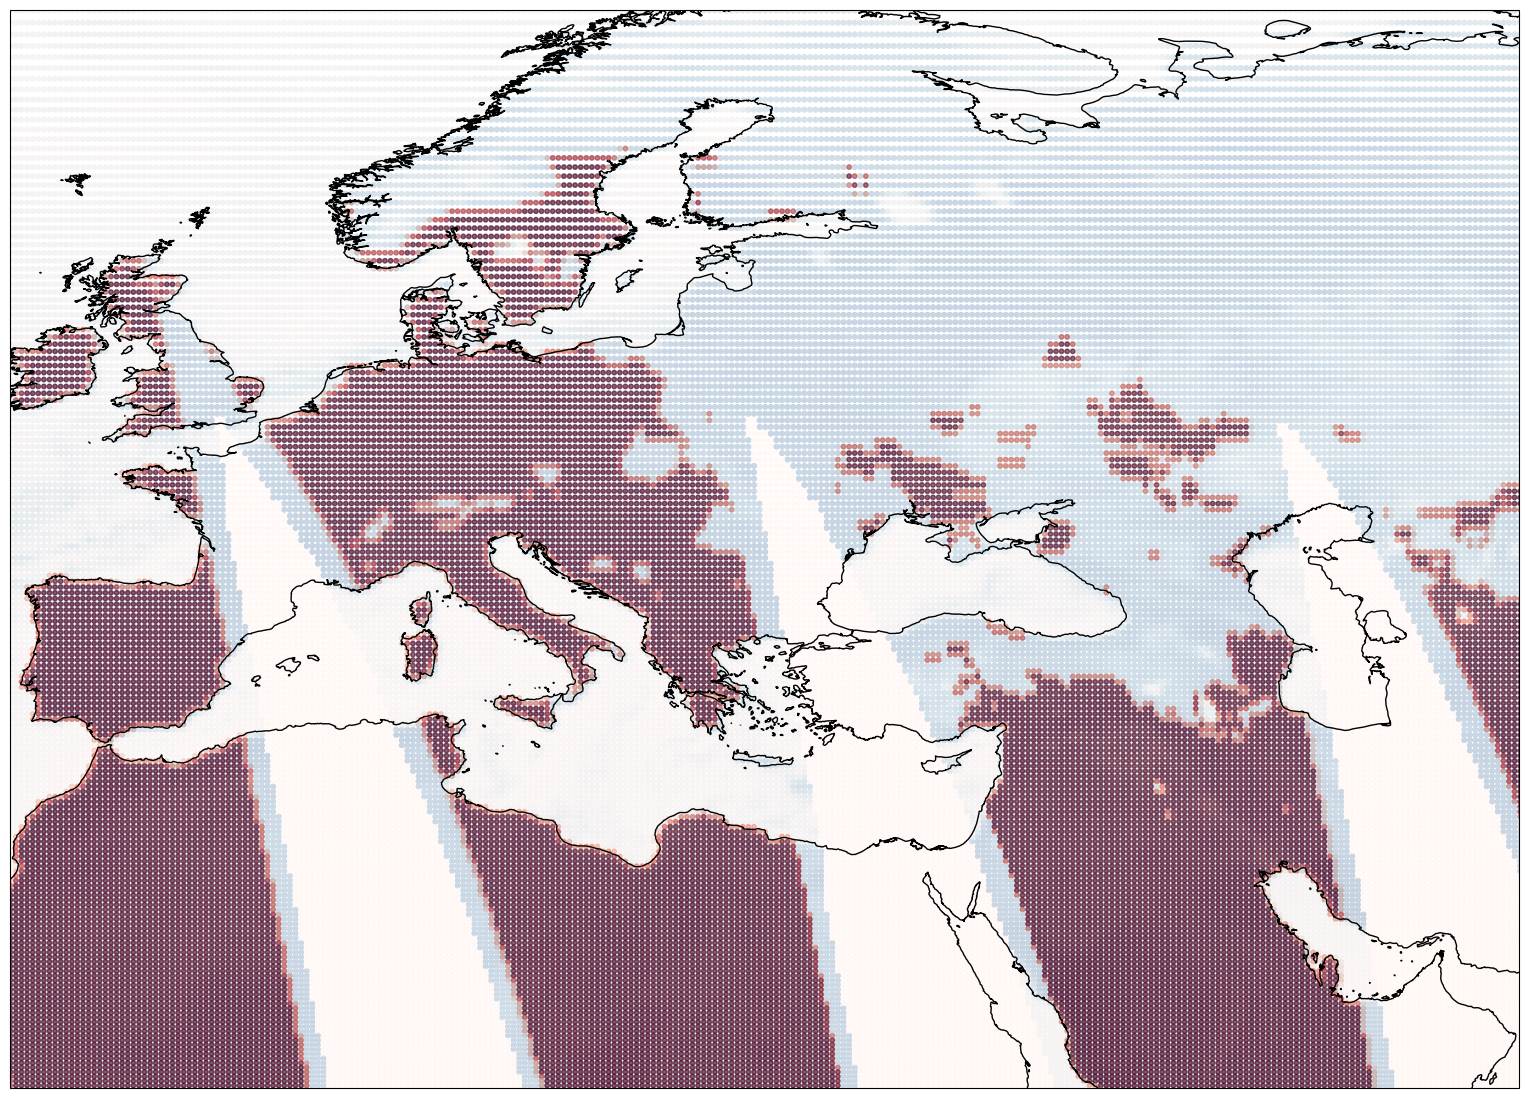

In [228]:
# Plot the pixel locations to make sure we projected properly:
# Scatterplot of the pixel locations:
# Extract the projected coordiantes as points. Do a meshgrid with lon and lat
lon1, lat1 = np.meshgrid(r_dataset.lon.values, r_dataset.lat.values)
lon1 = lon1.flatten()
lat1 = lat1.flatten()

# Do the same with the original V1 coordiantes
lon2, lat2 = np.meshgrid(v2_data.lon.values, v2_data.lat.values)
lon2 = lon2.flatten()
lat2 = lat2.flatten()

#Add the coastile objects to the lat-lon plot
import cartopy.crs as ccrs

fig,ax = plt.subplots(1,1,figsize=(28,14), subplot_kw={"projection":ccrs.PlateCarree()})
ax.coastlines("10m")
ax.scatter(lon2,lat2,s=10, c=v2_data["Brightness Temperature (H)"].values, alpha=0.5, marker = 'o', cmap="Blues")

#
ax.scatter(lon1,lat1,s=10,c=r_dataset.sel(band=3), alpha=0.5, marker = 'o', cmap="Reds")

x_lims = (-10,60)
y_lims = (20,70)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

(60.0, 70.0)

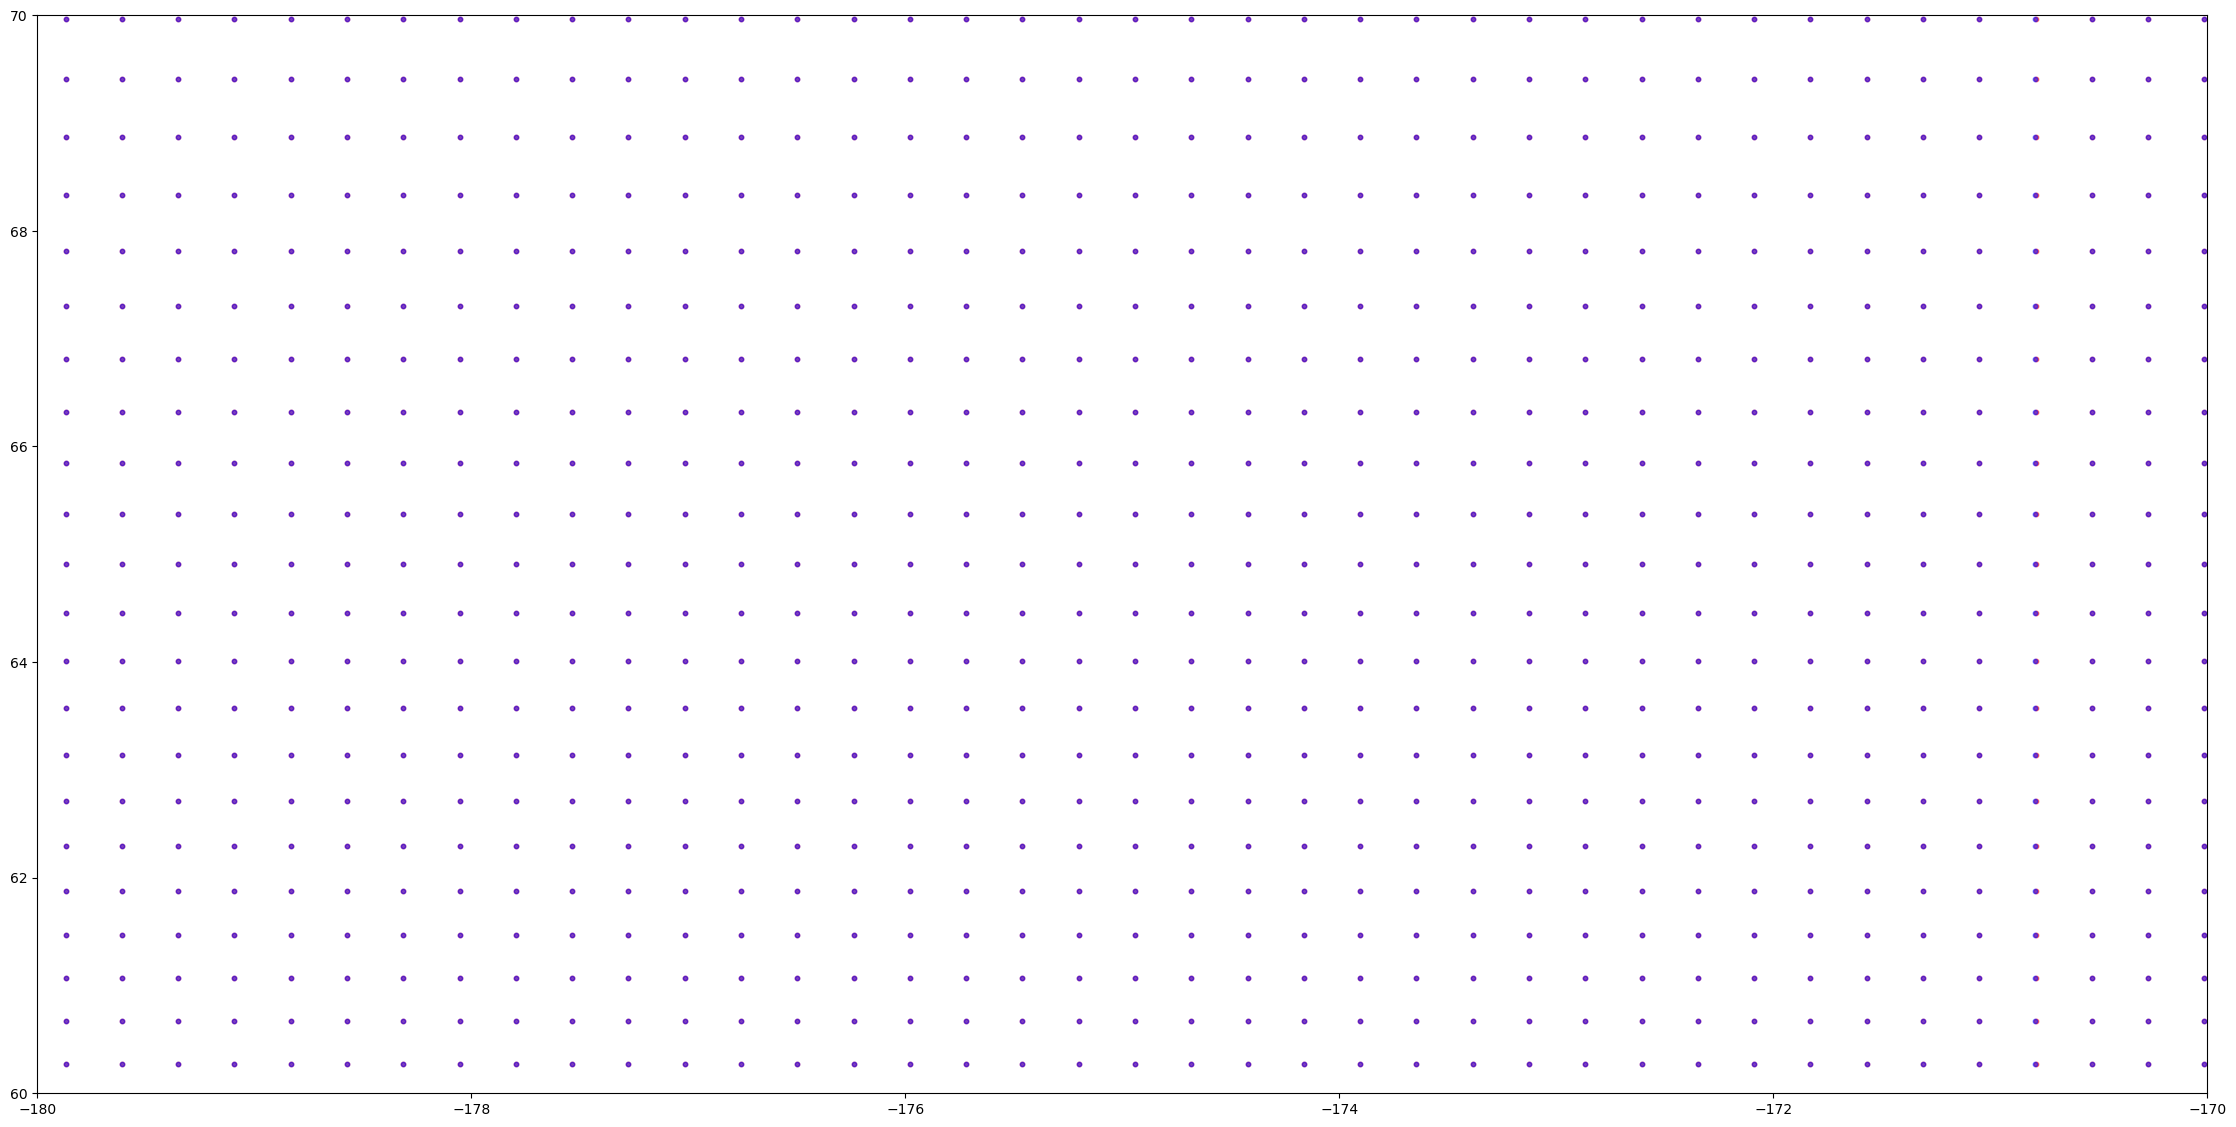

In [229]:
# Only the lat-lon points
fig,ax = plt.subplots(1,1,figsize=(28,14))
ax.scatter(lon2,lat2,s=10, color="Red", alpha=0.5)

ax.scatter(lon1,lat1,s=10,color = "Blue", alpha=0.5)

# Plot zoom:
x_lims = (-180,-170)
y_lims = (60,70)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

---

Looking at this, it looks fine but the origin of the pixel might be shifted ?

In [16]:
# Compare it with the ease_grid instead:
# Create a empty xarray with tha lat-lon values of the EASEv2 grid
from ease_grid import EASE2_grid

egrid = EASE2_grid(25000)
easegrid_array = xarray.DataArray(
    data=np.ones(shape=(egrid.shape)),
    coords={
        "lat" : egrid.latdim,
        "lon" : egrid.londim
    }
)
easegrid_array


<xarray.DataArray (lat: 584, lon: 1388)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lat      (lat) float64 83.52 81.98 80.7 79.57 ... -79.57 -80.7 -81.98 -83.52
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

(20.0, 70.0)

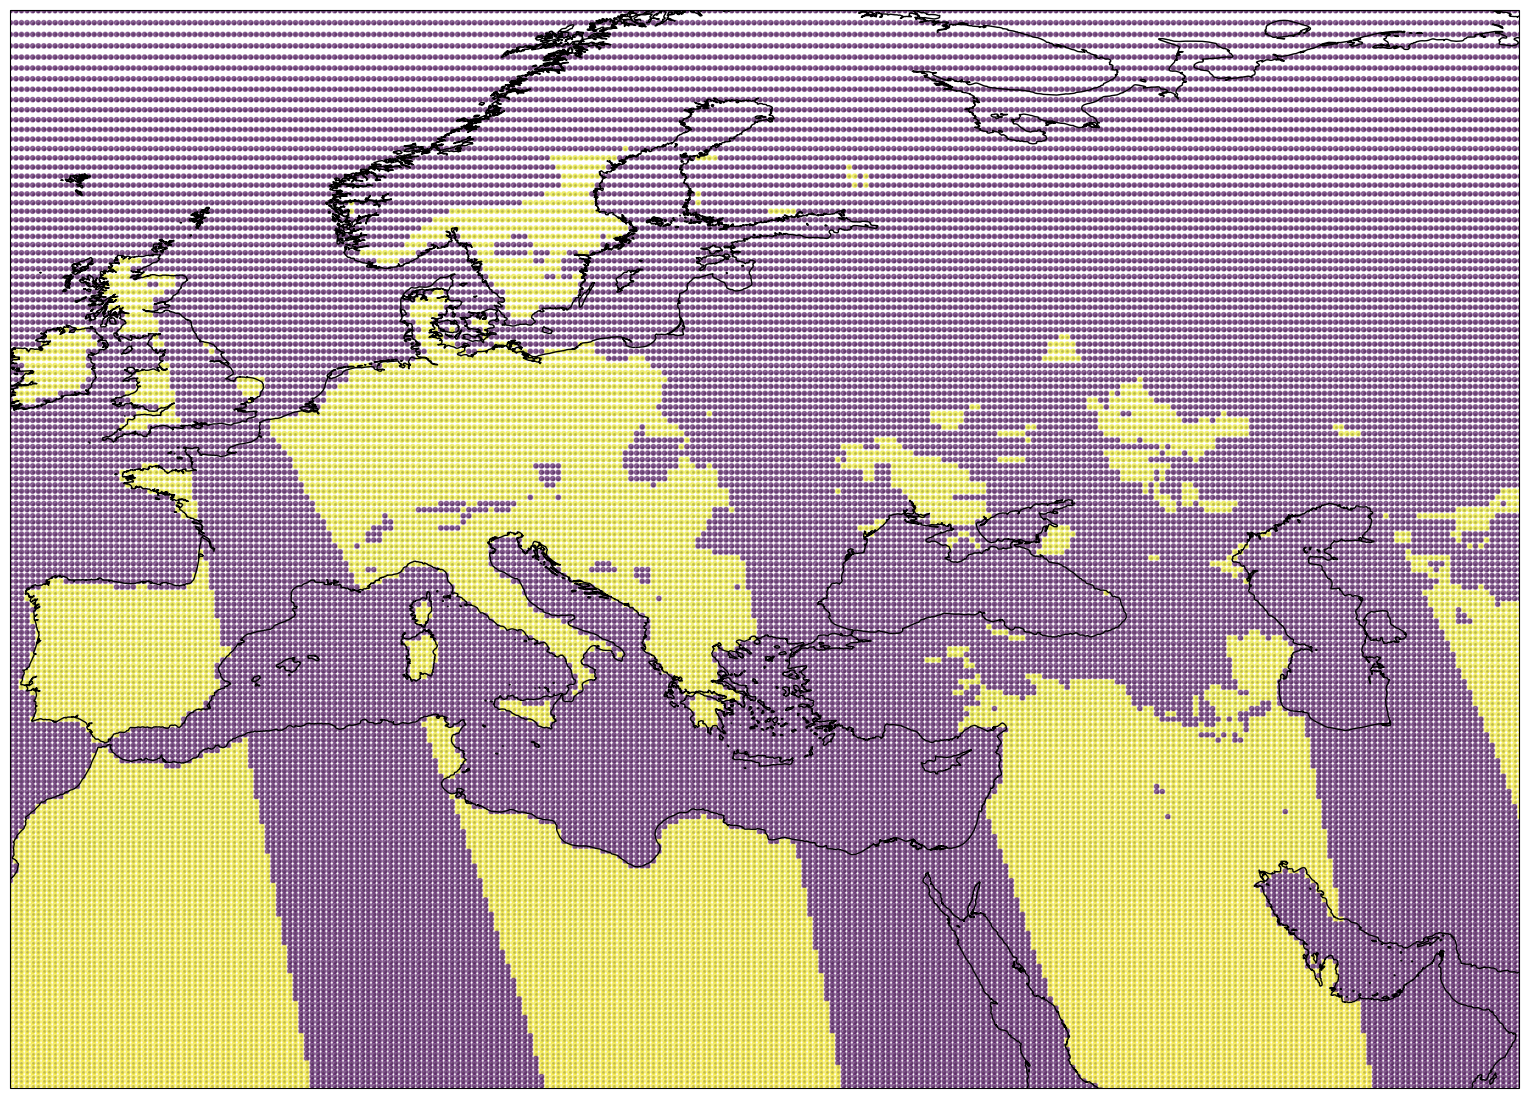

In [185]:
# Plot the pixel locations to make sure we projected properly:
# Scatterplot of the pixel locations:
# Extract the projected coordiantes as points. Do a meshgrid with lon and lat
lon1, lat1 = np.meshgrid(r_dataset.lon.values, r_dataset.lat.values)
lon1 = lon1.flatten()
lat1 = lat1.flatten()

# Do the same with the original V1 coordiantes
lon2, lat2 = np.meshgrid(easegrid_array.lon.values, easegrid_array.lat.values)
lon2 = lon2.flatten()
lat2 = lat2.flatten()

#Add the coastile objects to the lat-lon plot
import cartopy.crs as ccrs

fig,ax = plt.subplots(1,1,figsize=(28,14), subplot_kw={"projection":ccrs.PlateCarree()})
ax.coastlines("10m")
ax.scatter(lon2,lat2,s=2, alpha=0.3, marker = 'o', color ="black")

#
ax.scatter(lon1,lat1,s=10,c=r_dataset.sel(band=3), alpha=0.5, marker = 'o', cmap="viridis")

x_lims = (-10,60)
y_lims = (20,70)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

(30.0, 40.0)

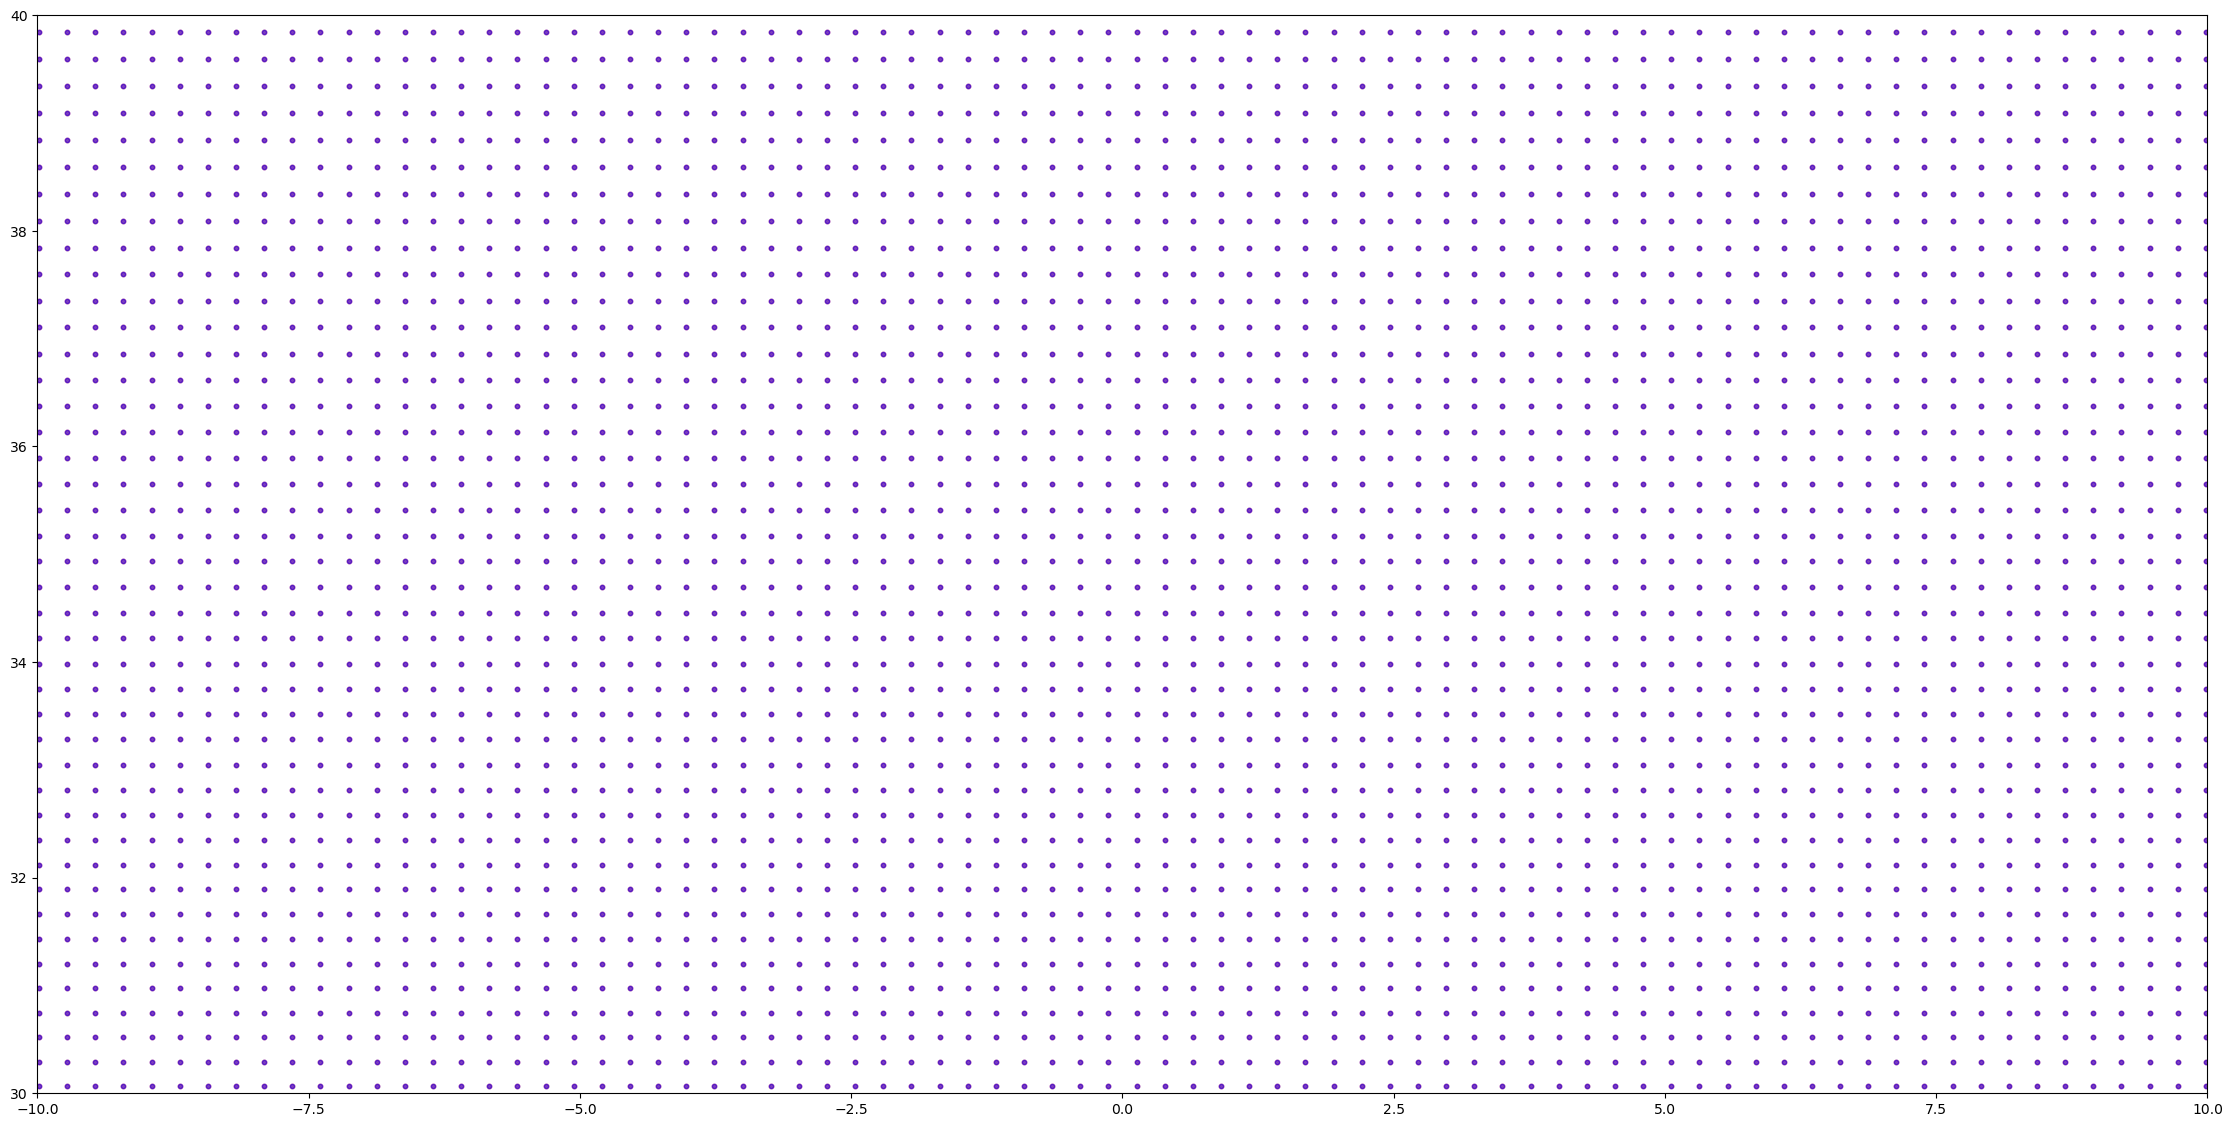

In [186]:
# Only the lat-lon points
fig,ax = plt.subplots(1,1,figsize=(28,14))
ax.scatter(lon2,lat2,s=10, color="Red", alpha=0.5)

ax.scatter(lon1,lat1,s=10,color = "Blue", alpha=0.5)

# Plot zoom:
x_lims = (-10,10)
y_lims = (30,40)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

---

Forget the coordinates, plot the arrays

In [187]:
r_arr = r_dataset.sel(band=3).values
# v2_arr = v2_data["Brightness Temperature (H)"].values

v2_data["amsr2_r"] = xarray.DataArray(
    data=r_arr[::-1,:], # Rows are fipped
    dims = ["lat","lon"],
)
v2_data

<xarray.Dataset>
Dimensions:                     (lon: 1388, lat: 584)
Coordinates:
  * lon                         (lon) float32 -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 -83.52 -81.98 ... 81.98 83.52
Data variables:
    Brightness Temperature (H)  (lat, lon) float32 204.9 204.8 ... 198.9 198.8
    Brightness Temperature (V)  (lat, lon) float32 234.3 234.1 ... 217.9 218.0
    Time Information            (lat, lon) float32 -286.0 -286.0 ... -1.026e+03
    amsr2_r                     (lat, lon) float32 -999.0 -999.0 ... -999.0
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

(20.0, 70.0)

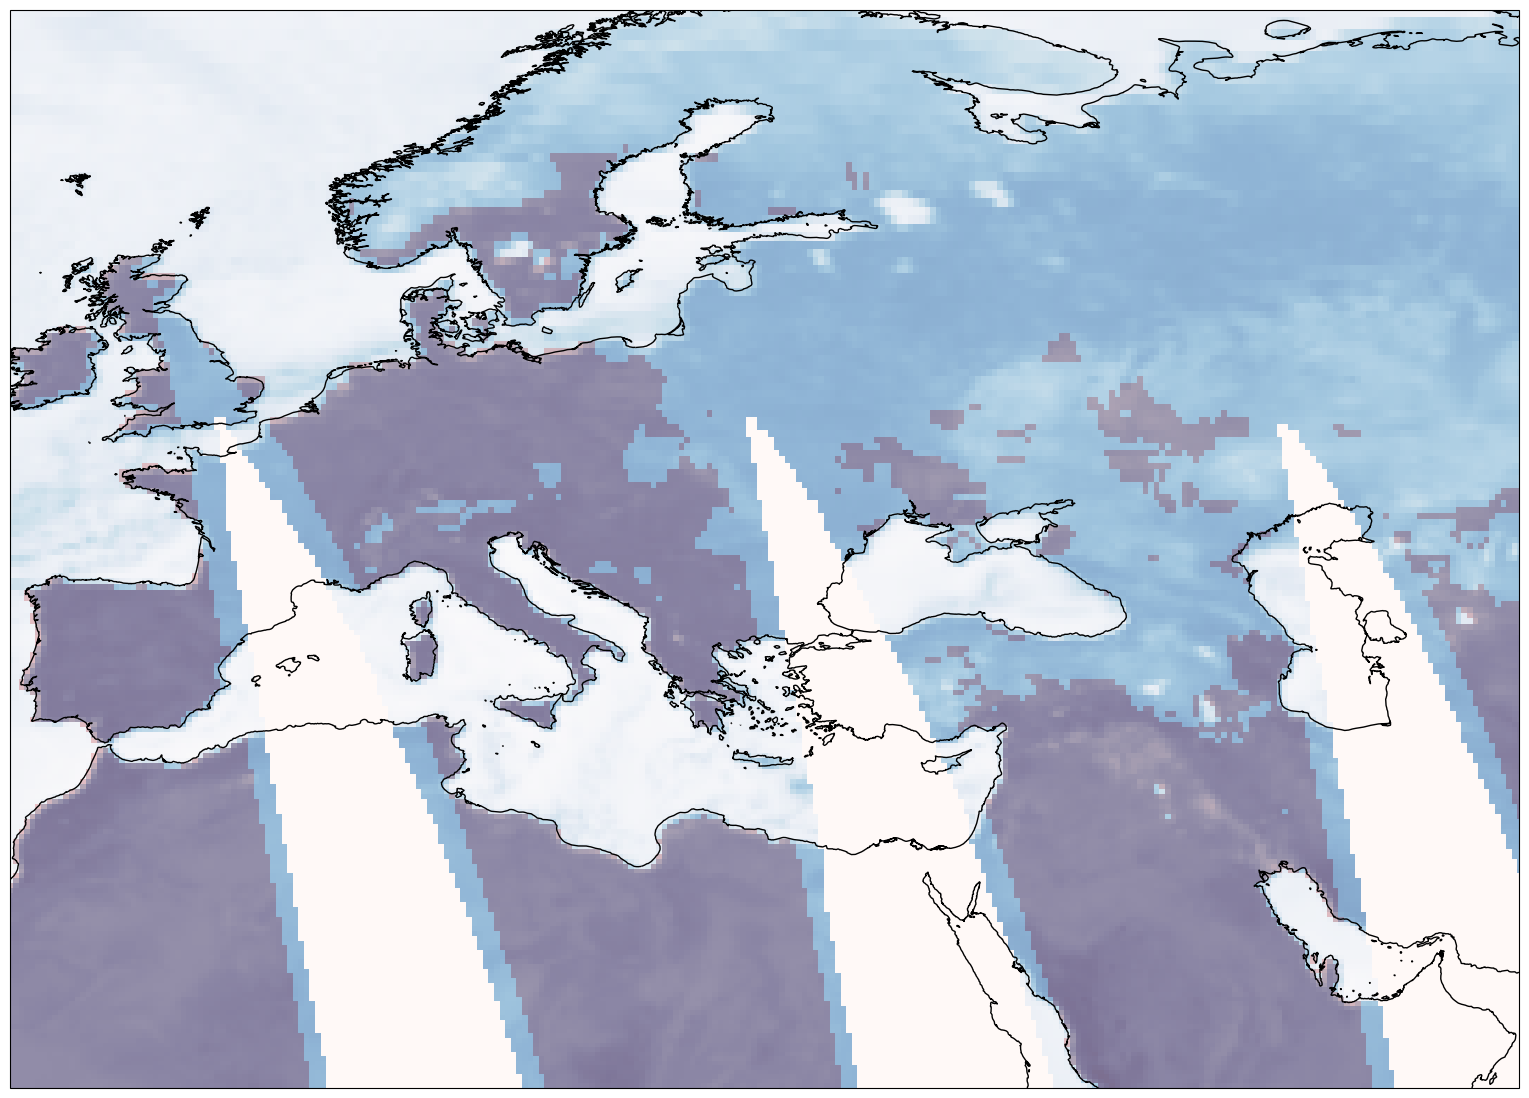

In [188]:
import cartopy.crs as ccrs
fig,ax = plt.subplots(1,1,figsize=(28,14), subplot_kw={"projection":ccrs.PlateCarree()})

ax.coastlines("10m")
v2_data.amsr2_r.plot(ax=ax, alpha = 0.5, cmap ="Reds", add_colorbar = False)
v2_data["Brightness Temperature (H)"].plot(ax=ax, alpha = 0.5, cmap = "Blues", add_colorbar = False)

x_lims = (-10,60)
y_lims = (20,70)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])


yeah, it does not work ... 